# **S&P 100 Portfolio Analysis**
### Conor Hanley,  Zach McDaniel, Greg Nebel, Vincent Parcelli, Jack Wells

## **Goal**
### This code can be used to optimize a portfolio of companies within the S&P 100 through Sharpe Ratio maximization. Additionally, we will use an Environmental, Social, and Governance (ESG) filter to select only the most sustainably conscious companies to invest in. ESG is a widely debated metric for use in equity valuation, but investors have become increasingly interested in corporate sustainability. This code evaluates the performance of both a sustainable portfolio and a portfolio with less sustainable companies.  

## **Questions**
### - How can we use the Sharpe Ratio and sustainability scores to construct an optimized portfolio of the largest 100 public companies?
### - Will a portfolio of companies with the best ESG scores outperform a portfolio with lower scores? 
### - How does the performance of the most sustainable portfolio compare to the performance of the entire S&P 100?
### - How does the optimized sustainable portfolio’s performance compare to a random portfolio of securities selected from the S&P 100? 

## Importing Packages

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import random
import requests
from pandas_datareader import data
from datetime import datetime
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

# Reading in list of S&P 100 tickers

In [2]:
#reading in txt file with tickers
my_file = open('W_5_Python.txt', 'r')
content = my_file.read()
#putting tickers into a variable, each ticker is on a new line
SP100_tickers = content.split("\n")
my_file.close()

#removing empty line at the end and whitespace from
SP100_tickers = SP100_tickers[:-1]
SP100_tickers = [i.strip(' ') for i in SP100_tickers]

### Sample Output

In [3]:
print(SP100_tickers[:10])

['MMM', 'ABT', 'ABBV', 'ACN', 'ADBE', 'GOOGL', 'GOOG', 'MO', 'AMZN', 'AXP']


# Collecting adjusted close data on S&P 100 

In [4]:
%%time
#Collecting data from yahoo using pd data reader
adj_close_df = data.DataReader(SP100_tickers, 'yahoo', start='2016/11/15', end='2021/11/15')['Adj Close']
#converting data to numeric
adj_close_df = adj_close_df.apply(pd.to_numeric)

Wall time: 2min


### Sample output

In [5]:
adj_close_df.head(5)

Symbols,MMM,ABT,ABBV,ACN,ADBE,GOOGL,GOOG,MO,AMZN,AXP,...,UNP,UPS,UNH,B,VZ,V,WBA,WMT,DIS,WFC
Date,,,,,,,,,,,,,,,,,,,,,
2016-11-15,148.963608,36.437229,49.962421,107.223312,103.660004,775.159973,758.489990,45.618465,743.239990,67.282547,...,89.058685,97.320107,140.606827,41.520954,37.923485,75.909088,72.713676,63.999428,92.843964,45.306602
2016-11-16,147.999893,36.565376,48.905483,108.452797,104.080002,779.979980,764.479980,46.245804,746.489990,66.549088,...,88.070251,97.001968,139.932571,41.483360,38.371807,77.530769,72.635124,63.972546,94.193405,44.522640
2016-11-17,148.653809,36.968090,49.032642,109.423431,105.809998,786.159973,771.229980,46.356510,756.400024,66.641930,...,88.789108,97.586678,139.258270,41.239017,38.299759,78.489265,73.333603,62.001144,94.430969,45.220451
2016-11-18,148.817322,36.464691,48.094910,109.478897,105.019997,775.969971,760.539978,46.326988,760.159973,65.917763,...,89.705696,98.102577,138.039047,42.207016,38.483891,78.247200,72.704948,61.418667,93.357132,45.504757
2016-11-21,147.578278,36.391460,48.015427,110.634415,105.650002,784.799988,769.200012,47.005981,780.000000,66.419098,...,90.532379,98.627121,138.925766,42.998753,38.676025,79.089516,73.709053,62.162430,92.777458,44.901691


# Creating an ESG (sustainability) score table for the S&P 100

## Collecting ESG score percentiles for the S&P 100 from Yahoo Finance

In [6]:
%%time
# Intitializing an empty list
esg_data = []

# Retrieve Yahoo! Finance Sustainability Scores for each ticker
for i in SP100_tickers:
    # using yf package Ticker method for each ticker in SP100 list
    i_y = yf.Ticker(i)
    try:
        # getting sustianability data for ticker
        if i_y.sustainability is not None:
            # storing sustainability in a data frame temp
            temp = pd.DataFrame(i_y.sustainability)
            # adding ticker to the table as a string
            temp['company_ticker'] = str(i_y.ticker)
            percentile = temp.loc['percentile']
            esg_data.append(temp.loc['percentile'])
            
    except IndexError:
        pass

Wall time: 7min 50s


## Sample of ESG score percentile table

In [9]:
#Converting to df
esg_scores = pd.DataFrame(esg_data)
#Output
esg_scores.head(10)

,Value,company_ticker
percentile,75.51,MMM
percentile,44.64,ABT
percentile,49.74,ABBV
percentile,3.10,ACN
percentile,2.49,ADBE
percentile,32.95,GOOGL
percentile,38.57,MO
percentile,62.88,AMZN
percentile,22.31,AXP
percentile,49.76,AIG


# ESG Portfolio Filter Function

In [10]:
# Defining Function
def esg_portfolio_filter(data = esg_scores, cutoff = 20):
        #Initializing empty list for output
        esg_cutoff_tickers = []
        #Appending tickers of companies above cutoff
        for i in esg_scores['company_ticker'][esg_scores['Value'] > cutoff]:
                esg_cutoff_tickers.append(i)
        return esg_cutoff_tickers

### Testing function output

In [11]:
portfolio_esg_above_70 = esg_portfolio_filter(esg_scores, 70)
portfolio_esg_above_70

['MMM', 'BA', 'CAT', 'CVX', 'COP', 'XOM', 'GD', 'GE', 'KHC', 'SO', 'WFC']

# Random Portfolio Function

In [12]:
## Function for getting random portfolio

def randomPort(numCompanies = 10, tickers = SP100_tickers):
    randomNums = []
    randTicks = []
    for i in range(numCompanies):
        randomNums.append(random.randint(0,100))
    for x in randomNums:
        randTicks.append(tickers[x])
    return randTicks

### Testing function output

In [13]:
test = randomPort(10, SP100_tickers)
test

['V', 'PM', 'V', 'AMT', 'CAT', 'JNJ', 'C', 'AVGO', 'CVX', 'AVGO']

# Portfolio info table generator function 

In [14]:
#Function
def portfolio_info_table_generator(portfolio, rfr = .0163):

    #Initializing an empty sharpe_ratio_table to store sharpe ratio data for each ticker
    portfolio_info_table = pd.DataFrame()

    #For loop to get needed variables for each ticker into a table
    for i in portfolio:
        #subsetting data to ticker specfic
        temp = adj_close_df[i]
        #coerce to data frame
        temp = pd.DataFrame(temp)
        col = i
        #calculating the return for each day
        temp['log_ret'] = np.log(temp["{}".format(col)] / temp["{}".format(col)].shift(1))
        
        #establishing variable for dictionary of company
        ticker = temp.columns[0]
        avg_return = temp.log_ret.mean()
        stdev = temp.log_ret.std()
        sharpe_ratio = (avg_return - rfr) / (stdev)

        #Putting selected variables into a dictionary
        dictionary = {}
        dictionary['ticker'] = ticker
        dictionary['avg_return'] = avg_return
        dictionary['stdev_of_return'] = stdev
        dictionary['risk_free_rate'] = rfr
        dictionary['sharpe_ratio'] = sharpe_ratio
        portfolio_info_table = portfolio_info_table.append(dictionary, ignore_index= True)

    return portfolio_info_table

## Testing Function

In [15]:
# Making a portfolio of first 10 tickers in SP100 list
SP100_portfolio = SP100_tickers
rfr = .0163
# Testing Function
SP100_table = portfolio_info_table_generator(SP100_portfolio, rfr)
#ouptut
SP100_table.head()

,avg_return,risk_free_rate,sharpe_ratio,stdev_of_return,ticker
0,0.000158,0.0163,-1.027219,0.015714,MMM
1,0.001008,0.0163,-0.977182,0.015649,ABT
2,0.000675,0.0163,-0.877122,0.017814,ABBV
3,0.000981,0.0163,-0.985392,0.015546,ACN
4,0.001471,0.0163,-0.734200,0.020197,ADBE


## Visualizing Portfolio

### Portfolio return plot function

In [16]:
#Bar plot of each avg return of the random stocks chosen from function
def plot_returns(portfolio):
    avgRetRandom = {}
    avgRetRandom['Stocks'] = portfolio
    avgRetRandom['Avg_Returns'] = []
    for stock in portfolio:
        onlyStock = SP100_table[SP100_table['ticker'] == stock]
        avgRetRandom['Avg_Returns'].append(onlyStock.iloc[0]['avg_return'])

    randomRetsDF = pd.DataFrame(avgRetRandom)
    randomRetsDF = randomRetsDF.set_index('Stocks')

    return randomRetsDF.plot(kind = 'bar', title = 'Average Daily Returns for Each Stock in Portfolio', figsize = (15,10))


<AxesSubplot:title={'center':'Average Daily Returns for Each Stock in Portfolio'}, xlabel='Stocks'>

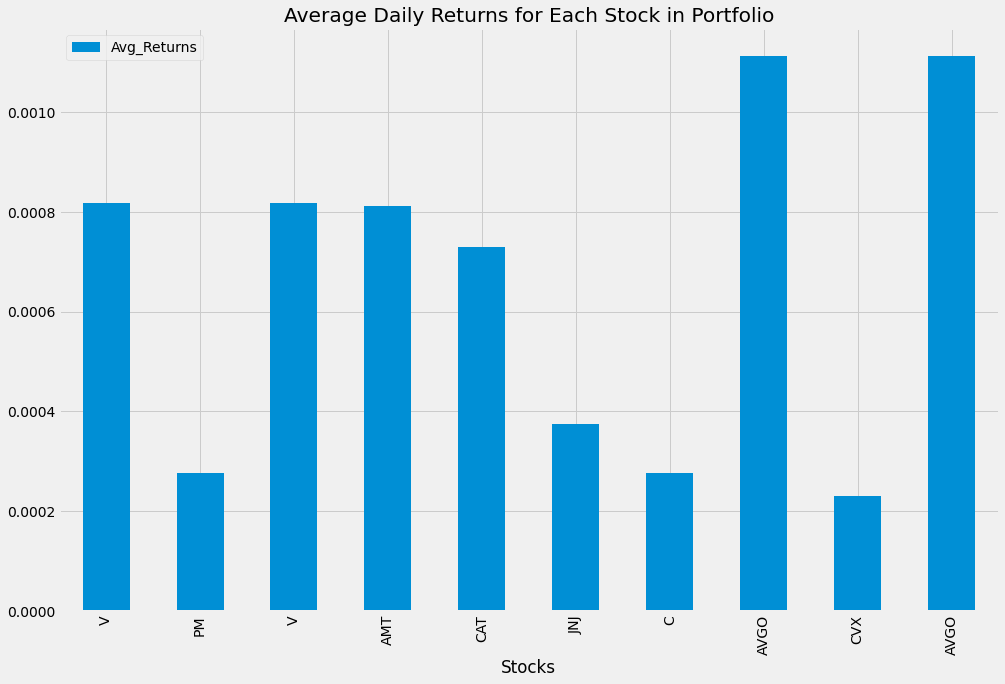

In [17]:
plot_returns(test)

<AxesSubplot:title={'center':'Average Daily Returns for Each Stock in Portfolio'}, xlabel='Stocks'>

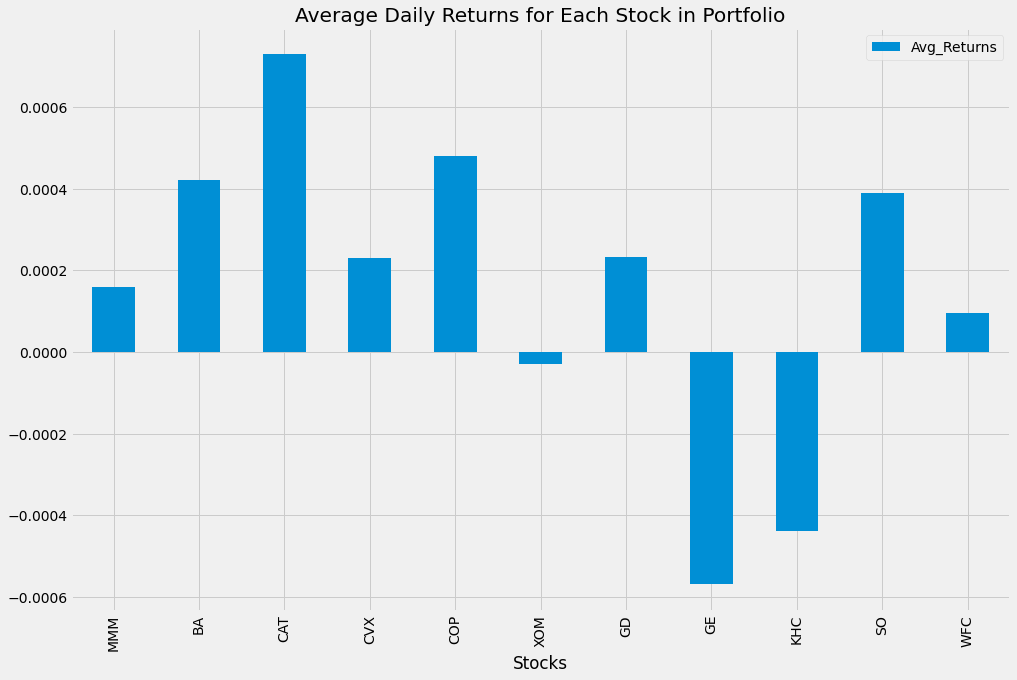

In [18]:
plot_returns(portfolio_esg_above_70)

# Portfolio comparison function

In [19]:
# Defining comparison function
def compare_portfolios(portfolio1, portfolio2, rfr = .0163):
    portfolio1_SharpeRatio = (portfolio1.avg_return.mean() - rfr) / portfolio1.stdev_of_return.mean()
    portfolio2_SharpeRatio = (portfolio2.avg_return.mean() - rfr) / portfolio2.stdev_of_return.mean()
    
    if portfolio1_SharpeRatio > portfolio2_SharpeRatio:
        return print('The first portfolio has a greater sharpe ratio of {} > {}'.format(portfolio1_SharpeRatio, portfolio2_SharpeRatio))
    else:
        return print('The second portfolio has a greater sharpe ratio of {} > {}'.format(portfolio2_SharpeRatio, portfolio1_SharpeRatio))
    

## Comparing a random portfolio to esg portfolio

In [20]:
#Creating randomized portfolio
random_portfolio = randomPort()
RandomPort_info_table = portfolio_info_table_generator(random_portfolio, rfr = .0163)

#Creating a portfolio of first 10 tickers in S&P 100 list
esg_portfolio = portfolio_esg_above_70
esg_portfolio_info_table = portfolio_info_table_generator(esg_portfolio, rfr = .0163)

print('1) esg portfolio: {}'.format(esg_portfolio))
print('2) random portfolio: {}'.format(random_portfolio))
print('\n')

#Testing function
compare_portfolios(esg_portfolio_info_table, RandomPort_info_table, .0163)

1) esg portfolio: ['MMM', 'BA', 'CAT', 'CVX', 'COP', 'XOM', 'GD', 'GE', 'KHC', 'SO', 'WFC']
2) random portfolio: ['AMGN', 'BK', 'PM', 'NKE', 'BIIB', 'CVX', 'MDT', 'AMZN', 'MMM', 'BRK-B']


The first portfolio has a greater sharpe ratio of -0.7707352248415393 > -0.872336544801312


# Porfolio Optimization

## Making ESG filtered portfolio to be optimized

In [21]:
#get stock tickers
assets = esg_portfolio_filter(data = esg_scores, cutoff = 70)

#get portfolio/asset start date
StockStartDate = '2013-01-01'

#get stocks ending date (today)
today = datetime.today().strftime('%Y-%m-%d')

#create dataframe to store adjusted close price of the assets
df = pd.DataFrame()

#store the adjusted close price in the df using a loop
for stock in assets:
    df[stock] = data.DataReader(stock, data_source='yahoo', start = StockStartDate, end = today)['Adj Close']

## Visualizing portfolio adjusted close prices over time

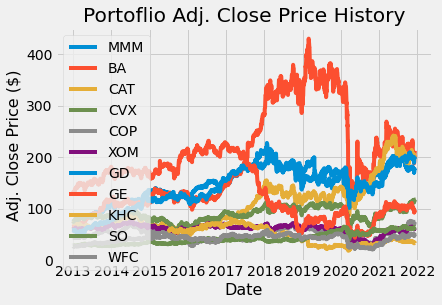

In [22]:
#visually show the asset portfolio
title = 'Portoflio Adj. Close Price History'

#get stocks
my_stocks = df

# Create and Plot the Graph
for c in my_stocks.columns.values:
    plt.plot(my_stocks[c], label = c)
    
plt.title(title)
plt.xlabel('Date', fontsize = 16)
plt.ylabel('Adj. Close Price ($)', fontsize = 16)
plt.legend(my_stocks.columns.values, loc = 'upper left')
plt.show()

## Calculating Portfolio Metrics for Optimization

### Weights for distribution in portfolio

In [23]:
#assign equal weights to assets
weights = np.full(len(df.columns), 1/len(df.columns))
weights

array([0.09090909, 0.09090909, 0.09090909, 0.09090909, 0.09090909,
       0.09090909, 0.09090909, 0.09090909, 0.09090909, 0.09090909,
       0.09090909])

In [24]:
# Get Daily Simple Returns
returns = df.pct_change()
returns.head()

,MMM,BA,CAT,CVX,COP,XOM,GD,GE,KHC,SO,WFC
Date,,,,,,,,,,,
2013-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-03,-0.001160,0.005190,0.009626,-0.004258,-0.000676,-0.001804,0.003932,-0.011246,NaN,-0.000228,-0.008274
2013-01-04,0.007394,0.002840,0.005508,0.005277,0.011155,0.004630,-0.005875,0.004739,NaN,0.008910,0.005178
2013-01-07,0.001258,-0.020079,0.003056,-0.006787,-0.011032,-0.011578,0.011116,-0.003301,NaN,-0.017437,-0.004865
2013-01-08,0.000105,-0.026271,-0.012709,-0.004465,-0.013520,0.006255,-0.020178,-0.010885,NaN,-0.002766,-0.001726


In [25]:
# Create and show the annualized covariance matrix
cov_matrix_annual = returns.cov() * 252
cov_matrix_annual.head()

,MMM,BA,CAT,CVX,COP,XOM,GD,GE,KHC,SO,WFC
MMM,0.045426,0.035525,0.035855,0.030453,0.034075,0.028552,0.028224,0.035205,0.028435,0.016149,0.032903
BA,0.035525,0.144048,0.052118,0.059549,0.067199,0.052914,0.048133,0.067135,0.036055,0.025843,0.062543
CAT,0.035855,0.052118,0.077361,0.045684,0.058347,0.042381,0.034346,0.046646,0.029830,0.015423,0.044210
CVX,0.030453,0.059549,0.045684,0.080981,0.085236,0.060587,0.033502,0.049524,0.034853,0.021031,0.048935
COP,0.034075,0.067199,0.058347,0.085236,0.136355,0.073467,0.037297,0.059450,0.038975,0.018630,0.058379


In [26]:
# Calculate Portfolio Variance
port_variance = np.dot(weights.T, np.dot(cov_matrix_annual, weights))
port_variance

0.04400355847476575

In [27]:
# Calculate Portfolio Volatility (also known as portfolio standard deviation or portfolio risk)
port_volatility = np.sqrt(port_variance)
port_volatility

0.20977025164394916

In [28]:
# Calculate the annual portfolio return
PortfolioSimpleAnnualReturn = np.sum(returns.mean() * weights) * 252
PortfolioSimpleAnnualReturn

0.10081833594799539

### Output Metrics

In [29]:
# Show portfolio expected annual return, volatility, and variance
percent_var = str(round(port_variance, 2) * 100) + '%'
percent_vols = str(round(port_volatility, 2) * 100) + '%'
percent_ret = str(round(PortfolioSimpleAnnualReturn, 2) * 100) + '%'

print('Expected Annual Return: '+ percent_ret)
print('Annual Volatility: '+ percent_vols)
print('Annual Variance: '+ percent_var)

Expected Annual Return: 10.0%
Annual Volatility: 21.0%
Annual Variance: 4.0%


# Portfolio Optimization 

In [35]:
# Portfolio Optimization

# Calculate Expected Returns and the annualized sample covariance matrix of asset returns
mu = expected_returns.mean_historical_return(df)
S = risk_models.sample_cov(df)

# Optimize by maximizing the Sharpe Ratio (maximizing risk adjusted return of a portfolio)
ef = EfficientFrontier(mu, S)
weights = ef.max_sharpe()
cleaned_weights = ef.clean_weights()
print(cleaned_weights)
ef.portfolio_performance(verbose = True)

OrderedDict([('MMM', 0.0), ('BA', 0.0), ('CAT', 0.07676), ('CVX', 0.0), ('COP', 0.0), ('XOM', 0.0), ('GD', 0.70451), ('GE', 0.0), ('KHC', 0.0), ('SO', 0.21873), ('WFC', 0.0)])
Expected annual return: 13.6%
Annual volatility: 19.2%
Sharpe Ratio: 0.60


(0.13585635233824753, 0.1918960642250843, 0.6037453285251017)

## Pie chart of portfolio distribution

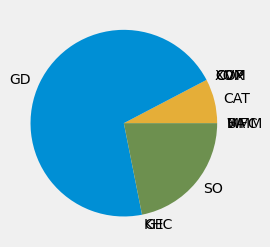

In [36]:
values = cleaned_weights.values()
values_list = list(values)
names = cleaned_weights.keys()
names_list = list(names)

plt.pie(values_list,labels = names_list)
plt.show()

## Fund allocation per stock in portfolio

In [31]:
# Get the discrete allocation of shares of stock
from pypfopt.discrete_allocation import DiscreteAllocation, get_latest_prices

latest_prices = get_latest_prices(df)
weights = cleaned_weights
da = DiscreteAllocation(weights, latest_prices, total_portfolio_value = 1000000)

allocation, leftover = da.lp_portfolio()
print('Discrete Allocation: ', allocation)
print('Cash Remaining: ${:.2f}'.format(leftover))

Discrete Allocation:  {'CAT': 376, 'GD': 3505, 'SO': 3392}
Cash Remaining: $16.69


## Ending Portfolio

In [37]:
## Creating end porfolio table
Data_items = allocation.items() 
Data_list = list(Data_items)
df1 = pd.DataFrame(Data_list)
Data_principal = latest_prices.items()
df2 = pd.DataFrame(Data_principal)
df3 = pd.merge(df1, df2, on=0)
df4 = df3.rename(columns={0: "Ticker",'1_x': 'Shares', '1_y': 'Price'})
df4['Principal']=df4['Shares'] * df4['Price']
decimals = pd.Series([2,2], index=['Price','Principal'])
df4.round(decimals)


,Ticker,Shares,Price,Principal
0,CAT,376,204.29,76813.04
1,GD,3505,201.00,704505.00
2,SO,3392,64.46,218665.27


# **Conclusions**
### We found that the ESG 70+ portfolio performed better than several random portfolios.
### After optimizing our ESG rated 70+ portfolio, there was several overall improvements:
###  - Assests in portfolio went from 12 to 3
### - Final stocks were CAT, GD, and SO
###  - Annual Return increased by 3.6%
###  - Annual Volatility decreased by 1.8%
###  - Final Sharpe Ratio was .60